In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import cryptofxns as crypto
from matplotlib import pyplot as plt
%matplotlib inline

## Bring in genotype data

In [2]:
file_end = 'min-Geno-k6000.csv'
geno = pd.read_csv('../FILES/FiltGenotoHapFiltGeno-%s'%file_end)

In [3]:
geno.head()

,Alt,Chrom,Pos,Ref,SS-B307,SS-B308,SS-B310,SS-B311,SS-B312,SS-B313,...,SS-C029_Correction,SS-C031_Correction,SS-C033,SS-C036,SS-C039,SS-C242,SS-C271,SS-C272,SS-C290,SS-C291
0,A,Chr01,5016.0,C,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
1,C,Chr01,5299.0,T,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,C,Chr01,5464.0,T,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
3,C,Chr01,6120.0,T,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
4,A,Chr01,6166.0,G,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0


## Bring in old dataframe

In [4]:
old_CO_df = pd.read_csv("~/Desktop/CRYPTO_RECOMB/FILES/Crypto-GTC-co-anova-df-min-haplotype-k6000.csv")
new_CO_df = old_CO_df.copy()

In [65]:
old_CO_df.N.sum()

3297.0

## Double check that the crossover total old counts and totals from new counting methods match.

In [5]:
chrom_N = [old_CO_df[old_CO_df.Chrom==chrom].N.sum() for chrom in old_CO_df.Chrom.unique()];print chrom_N

[368.0, 301.0, 330.0, 292.0, 257.0, 217.0, 240.0, 287.0, 192.0, 185.0, 186.0, 139.0, 156.0, 147.0]


In [6]:
co_imi = crypto.IMIandCON(geno);
co_imi_chrom_N = [co_imi[co_imi.Chrom==chrom].XO.sum() for chrom in co_imi.Chrom.unique()];print co_imi_chrom_N

[368.0, 301.0, 330.0, 292.0, 257.0, 217.0, 240.0, 287.0, 192.0, 185.0, 186.0, 139.0, 156.0, 147.0]


#### We have convergence in our crossover methods as seen above. We can check numerically. 

In [7]:
assert sum(np.array(co_imi_chrom_N) - np.array(chrom_N)) == 0

In [8]:
reload(crypto);
tetrads = crypto.axalp
uni = [seg for seg in geno.columns.tolist()[4:] if seg not in np.concatenate(tetrads)];print len(uni)
bi = [seg for seg in geno.columns.tolist()[4:] if seg not in uni];print len(bi)
assert len(uni) + len(bi) == len(geno.T) - 4

55
39


## Recount for chromosome 7, the number of crossovers given the region around URA5

In [9]:
chr7_geno = geno[geno.Chrom=='Chr07'].copy()
co_imi_seg = [crypto.IMIandCON(chr7_geno[chr7_geno.columns.tolist()[:4]+[seg]]) for seg in chr7_geno.columns.tolist()[4:]]

In [10]:
len(co_imi_seg)

94

In [11]:
len_chr07_imi = [len(a) for a in co_imi_seg]

In [12]:
print np.unique(len_chr07_imi)
assert len(np.unique(len_chr07_imi)) == 1

[6135]


## Set window around ura5 locus

In [13]:
Ws = 5000
A =  crypto.ura5_start - Ws
B =  crypto.ura5_end + Ws

## Get index to that region in imi dataframes.
#### Here we assume all the imi dataframes have the same index. This was checked above

In [14]:
temp = co_imi_seg[0]
NAT_regionchr07 = temp[(temp.V > A) & (temp.W < B)].index.tolist()

In [15]:
len(NAT_regionchr07)

9

In [16]:
for a in co_imi_seg:
    a.drop(NAT_regionchr07,inplace=True)

In [17]:
print np.unique([len(a) for a in co_imi_seg])

[6126]


## Check our length of imi dataframe from dorpped and previous length match

In [18]:
np.unique([len(a) for a in co_imi_seg]) + len(NAT_regionchr07)

array([6135])

In [19]:
new_chr7_co = [a.XO.sum() for a in co_imi_seg]

In [20]:
tempdf = pd.DataFrame([[seg for seg in chr7_geno.columns.tolist()[4:]],new_chr7_co]).T
tempdf.columns = ['Seg','N']

In [21]:
len(old_CO_df[old_CO_df.Chrom=='Chr07'].sort_values(['Seg']))

94

In [22]:
segs = old_CO_df[old_CO_df.Chrom=='Chr07'].sort_values(['Seg'])['Seg'].tolist()

In [23]:
short_segs = [seg.split('_')[0] for seg in segs]

In [24]:
print len(short_segs)
print len(np.unique(short_segs))

94
94


In [25]:
for i, seg in enumerate(chr7_geno.columns.tolist()[4:]):
    assert seg.split('_')[0] == short_segs[i]

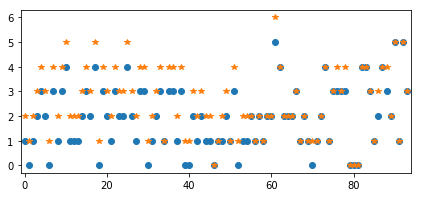

In [26]:
fig,ax = plt.subplots(1,1,figsize=(7,3))
tempdf.N.plot(marker='o',linestyle=' ');
old_CO_df[old_CO_df.Chrom=='Chr07'].sort_values(['Seg']).reset_index(drop=True).N.plot(marker='*',linestyle=' ')
plt.xlim(-1,94);

Above, all blue dots (new counts) should be below old counts (gold stars)

In [27]:
oldcount = old_CO_df[old_CO_df.Chrom=='Chr07'].sort_values(['Seg']).reset_index(drop=True).N.values
newcount = tempdf.N.values

In [28]:
changedsegs = []
for i, j in enumerate(oldcount):
    if j - newcount[i] > 0:
        changedsegs.append((short_segs[i],newcount[i]))

## Number of segregants with changed values for chr 7

In [29]:
len(changedsegs)

57

In [30]:
print changedsegs

[('SS-B307', 1.0), ('SS-B308', 0.0), ('SS-B310', 1.0), ('SS-B311', 2.0), ('SS-B312', 3.0), ('SS-B313', 2.0), ('SS-B314', 0.0), ('SS-B315', 3.0), ('SS-B316', 1.0), ('SS-B317', 3.0), ('SS-B350', 4.0), ('SS-B354', 1.0), ('SS-B356', 1.0), ('SS-B357', 1.0), ('SS-B358', 2.0), ('SS-B360', 3.0), ('SS-B364', 2.0), ('SS-B366', 4.0), ('SS-B368', 0.0), ('SS-B369', 3.0), ('SS-B373', 2.0), ('SS-B374', 1.0), ('SS-B378', 3.0), ('SS-B379', 2.0), ('SS-B382', 2.0), ('SS-B383', 4.0), ('SS-B387', 2.0), ('SS-B396', 1.0), ('SS-B397', 3.0), ('SS-B399', 3.0), ('SS-B407', 0.0), ('SS-B553', 1.0), ('SS-B563', 2.0), ('SS-B564', 3.0), ('SS-B569', 3.0), ('SS-B570', 3.0), ('SS-B574', 1.0), ('SS-B575', 3.0), ('SS-B579', 0.0), ('SS-B580', 0.0), ('SS-B584', 2.0), ('SS-B585', 1.0), ('SS-B586', 2.0), ('SS-B587', 1.0), ('SS-B588', 1.0), ('SS-B598', 1.0), ('SS-B599', 2.0), ('SS-B605', 3.0), ('SS-B606', 0.0), ('SS-B611', 1.0), ('SS-B621', 1.0), ('SS-B886', 5.0), ('SS-B908', 0.0), ('SS-B956', 3.0), ('SS-B961', 3.0), ('SS-C033

## Change name of segregatns in new df to new short names

In [31]:
new_old_segs = new_CO_df['Seg'].tolist()
new_short_segs = [seg.split('_')[0] for seg in new_old_segs]

In [32]:
new_CO_df['Seg'] = new_short_segs

## Make df with new values 

In [33]:
old_chroms = old_CO_df.drop(old_CO_df[old_CO_df.Chrom=='Chr07'].index,axis=0)

In [34]:
old_chroms.Chrom.unique()

array(['Chr01', 'Chr02', 'Chr03', 'Chr04', 'Chr05', 'Chr06', 'Chr08',
       'Chr09', 'Chr10', 'Chr11', 'Chr12', 'Chr13', 'Chr14'], dtype=object)

In [62]:
old_CO_df.N.sum()

3297.0

In [35]:
old_chroms.head()

,Chrom,Chrlen,Cross,N,Seg
0,Chr01,2300525,1,1.0,SS-B307
1,Chr01,2300525,1,2.0,SS-B308
2,Chr01,2300525,1,1.0,SS-B310
3,Chr01,2300525,1,3.0,SS-B311
4,Chr01,2300525,1,4.0,SS-B312


In [36]:
old_chroms['Seg'] = [a.split('_')[0] for a in old_chroms['Seg'].values]

In [37]:
old_CO_df['Seg'] = [a.split('_')[0] for a in old_CO_df['Seg'].values]

In [38]:
tempdf['Seg'] = [a.split('_')[0] for a in tempdf['Seg'].values]
tempdf['Chrom'] = ['Chr07' for a in newcount]
tempdf['Chrlen'] = old_CO_df[old_CO_df.Chrom=='Chr07']['Chrlen'].values
tempdf['Cross'] = [old_CO_df[(old_CO_df['Chrom']=='Chr07')&(old_CO_df['Seg']==seg)]['Cross'].tolist()[0] for seg in tempdf.Seg]

In [39]:
tempdf = tempdf[old_CO_df.columns]

In [40]:
new_CO_df = pd.concat([old_chroms,tempdf])

In [41]:
new_CO_df.sort_values(['Chrom','Seg'],inplace=True)

In [42]:
new_CO_df.head()

,Chrom,Chrlen,Cross,N,Seg
0,Chr01,2300525,1,1,SS-B307
1,Chr01,2300525,1,2,SS-B308
2,Chr01,2300525,1,1,SS-B310
3,Chr01,2300525,1,3,SS-B311
4,Chr01,2300525,1,4,SS-B312


In [63]:
new_CO_df.N.sum()

3240.0

In [43]:
new_CO_df.tail()

,Chrom,Chrlen,Cross,N,Seg
1311,Chr14,762695,2,3,SS-C242
1312,Chr14,762695,2,4,SS-C271
1313,Chr14,762695,2,1,SS-C272
1314,Chr14,762695,2,4,SS-C290
1315,Chr14,762695,2,2,SS-C291


In [44]:
len(new_CO_df.Seg.unique())

94

In [45]:
len(new_CO_df.Chrom.unique())

14

In [46]:
for chrom in new_CO_df.Chrom.unique():
    temp = new_CO_df[new_CO_df.Chrom==chrom]
    assert len(temp) == 94
    for seg in temp.Seg:
        oC = old_CO_df[(old_CO_df.Chrom==chrom)&(old_CO_df.Seg==seg)]['Cross'].tolist()[0]
        nC = temp[temp.Seg==seg]['Cross'].tolist()[0]
        assert oC == nC

In [47]:
print chrom_N

[368.0, 301.0, 330.0, 292.0, 257.0, 217.0, 240.0, 287.0, 192.0, 185.0, 186.0, 139.0, 156.0, 147.0]


In [48]:
print [new_CO_df[new_CO_df.Chrom==chrom]['N'].sum() for chrom in new_CO_df.Chrom.unique()]

[368.0, 301.0, 330.0, 292.0, 257.0, 217.0, 183.0, 287.0, 192.0, 185.0, 186.0, 139.0, 156.0, 147.0]


In [49]:
chrom_N[6] - [new_CO_df[new_CO_df.Chrom==chrom]['N'].sum() for chrom in new_CO_df.Chrom.unique()][6]

57.0

## Visually check work

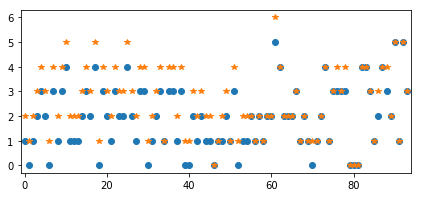

In [50]:
fig,ax = plt.subplots(1,1,figsize=(7,3))
new_CO_df[new_CO_df.Chrom=='Chr07'].sort_values(['Seg']).reset_index(drop=True).N.plot(marker='o',linestyle=' ')
old_CO_df[old_CO_df.Chrom=='Chr07'].sort_values(['Seg']).reset_index(drop=True).N.plot(marker='*',linestyle=' ')
plt.xlim(-1,94);

Should make the same figure as above

## Save new dataframe

In [64]:
new_CO_df.N.sum()

3240.0

In [51]:
new_CO_df.to_csv("~/Desktop/CRYPTO_RECOMB/FILES/Crypto-GTC-co-anova-df-min-haplotype-k6000-Feb2018.csv")

# Crossover analysis per chromosome and facte plot (on chromosome)

In [52]:
CO_u = new_CO_df[(new_CO_df.Cross==1)][['Chrom','N']]
CO_b = new_CO_df[(new_CO_df.Cross==2)][['Chrom','N']]

In [53]:
chrlist = new_CO_df.Chrom.unique()

In [54]:
mannxchrom = [ss.mannwhitneyu(CO_u[CO_u.Chrom==chrom]['N'].values,
                             CO_b[CO_b.Chrom==chrom]['N'].values) for chrom in chrlist]

In [55]:
from statsmodels.sandbox.stats.multicomp import multipletests as mltptest

In [56]:
mann_fdr_step_down_res = mltptest([mannxchrom[i][1] for i in range(len(chrlist))],method='hs',alpha=0.05)

In [57]:
[chrom for i, chrom in enumerate(chrlist) if mann_fdr_step_down_res[0][i] == True]

['Chr01', 'Chr02', 'Chr03', 'Chr04', 'Chr05', 'Chr08', 'Chr09']

In [58]:
import seaborn as sns
sns.set()
new_chrom_label = [str(int(chrom[3:])) for chrom in chrlist]
CO_anova_df = new_CO_df

In [59]:
for i,chrom in enumerate([chrom for i, chrom in enumerate(chrlist) if mann_fdr_step_down_res[0][i] == True]): ## For each chromsome ... 
    x1 = CO_anova_df[(CO_anova_df.Chrom==chrom)&(CO_anova_df.Cross==1)]['N'].tolist(); ## Get data for segs from unisexual reproduction
    x2 = CO_anova_df[(CO_anova_df.Chrom==chrom)&(CO_anova_df.Cross==2)]['N'].tolist(); 
    print chrom, abs(np.mean(x1) - np.mean(x2))

Chr01 1.06573426573
Chr02 1.18834498834
Chr03 1.05547785548
Chr04 1.30815850816
Chr05 1.46247086247
Chr08 1.2675990676
Chr09 0.935198135198


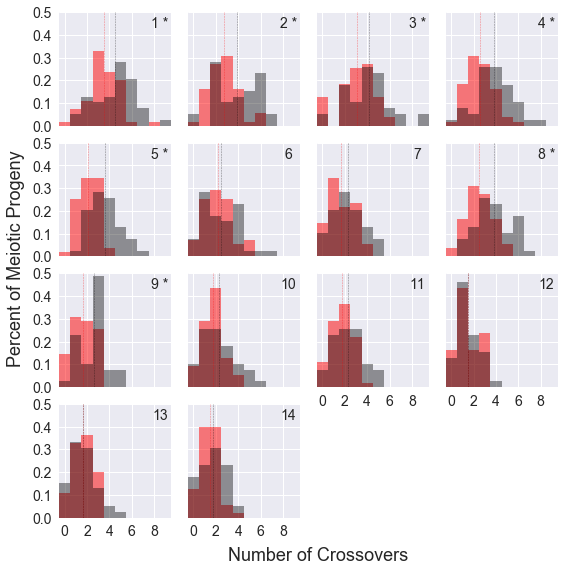

In [60]:
fig,ax = plt.subplots(4,4,figsize=(8,8),sharey=True); ## Call figure
bins = np.arange(-0.5,CO_anova_df.N.max()+1.5); ## Center bins on each integer from 0 to 10
tall = .6 ## Set variable for how tall the vertical lines representing the means shall be. 
uni_label = ' '
bi_label = ' '
for i,chrom in enumerate(chrlist): ## For each chromsome ... 
    plt.sca(ax.ravel()[i]); ## Get axis 
    x1 = CO_anova_df[(CO_anova_df.Chrom==chrom)&(CO_anova_df.Cross==1)]['N'].tolist(); ## Get data for segs from unisexual reproduction
    x2 = CO_anova_df[(CO_anova_df.Chrom==chrom)&(CO_anova_df.Cross==2)]['N'].tolist(); ## "" bisexual reproduction
    plt.hist(x1,bins=bins,color='r',alpha=.5,normed=True,label=uni_label); ## plot dist for segs from uni cross
    plt.hist(x2,bins=bins,color='k',alpha=.4,normed=True,label=bi_label); ## " " from bi cross 
    if mann_fdr_step_down_res[0][i] == True:
        chrom_label = new_chrom_label[i] + ' *';
    else:
        chrom_label = new_chrom_label[i]
    plt.text(0.9, 0.9,chrom_label, horizontalalignment='center', ## Label each subplot with the chromosome
                 verticalalignment='center', ## Align text centered vertically
                 transform = plt.gca().transAxes,fontsize=14); ## Turn axis to ratio
    plt.vlines(np.mean(x1),0,tall,'red',linestyles='--',linewidth=0.5,alpha=.5);
    plt.vlines(np.mean(x2),0,tall,'k',linestyles='--',linewidth=0.5,alpha=.5);
    for a in ['top','bottom','left','right']:
        plt.gca().spines[a].set_visible(False);
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5],fontsize=14);
    plt.xticks([0,2,4,6,8,10],fontsize=14); ## Set x and y ticks 
    plt.xlim(-.5,np.max(bins));#plt.ylim(0,25); ## Set x and y lims
    plt.tight_layout(); ## force a tight layout
    if i < 10: ## Turn off x axis for subplots not on bottom. 
        plt.gca().grid(True); ## Keep the grid in the background of these first plots
        plt.gca().set_xticklabels([]); ## Set their x ticks to none
for i in [14,15]: ## Turn off the two empty subplots
    plt.sca(ax.ravel()[i]); ## Get the axis
    plt.axis('off'); ## Turn it off. 
plt.subplots_adjust(wspace=0.15,hspace=0.15); ## Adjust space between subplots
plt.gcf().subplots_adjust(bottom=0.1);plt.gcf().subplots_adjust(left=0.1);
fig.text(0.55, 0.025, 'Number of Crossovers', ha='center',fontsize=18);
fig.text(0.01,0.55,'Percent of Meiotic Progeny',va='center', rotation='vertical',fontsize=18);
plt.ylim(0,0.5)
plt.sca(ax.ravel()[13])
##plt.legend(bbox_to_anchor=(2.0, 0.5));
plt.savefig('../FIGS/Crypto-11-GTC-Distributions.png',dpi=1200,bbox_inches='tight');